In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from util.util_cnn import *
from util.naming import *

from util.util_gamma_rule import calc_vals_batch
from util.util_data_summary import *
from util.vgg import *

import torchvision
from torchvision import transforms, datasets

In [2]:
%matplotlib inline

# Low dimensional toy model 
- plot development of gradients as we approach baseline

In [ ]:
class ToyModel(nn.Module):
    def __init__(self, x_0, x_1, hidden_sizes=[2], seed=42):
        super().__init__()

        # Set the seed for random initialization
        if seed is not None:
            torch.manual_seed(seed)

        self.x_0 = torch.tensor(x_0, dtype=torch.float, requires_grad=True)
        self.x_1 = torch.tensor(x_1, dtype=torch.float, requires_grad=True)
        self.x_0.retain_grad()
        self.x_1.retain_grad()

        assert self.x_0.shape == self.x_1.shape and self.x_0.ndim == 1

        activation_sizes = [len(self.x_0)] + hidden_sizes + [1]

        # Define linear layers and initialize weights and biases randomly
        self.layers = nn.ModuleList()  # Use ModuleList to store layers
        for inp, out in zip(activation_sizes[:-1], activation_sizes[1:]):
            layer = nn.Linear(inp, out, bias=True)
            # Initialize weights and biases randomly
            nn.init.normal_(layer.weight, mean=0, std=0.4)
            nn.init.normal_(layer.bias, mean=.5, std=0.2)
            self.layers.append(layer)


    def forward(self, t):
        assert 0 <= t <= 1
        self.activations = []
        
        x = self.x_1 * (1-t) + self.x_0 * t
        x.retain_grad()
        self.activations.append(x)  # Store the input (x) activation

        for layer in self.layers:
            h = F.relu(layer(self.activations[-1]))
            h.retain_grad()
            self.activations.append(h)

        return self.activations[-1]

In [ ]:
inputs = torch.tensor([[2,-3,5]])
outputs = torch.tensor([[0,0,0]])

/var/folders/lb/gcgcmyt11lq2rbpmsb109yfh0000gn/T/ipykernel_53576/3698739428.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x_0 = torch.tensor(x_0, dtype=torch.float, requires_grad=True)
/var/folders/lb/gcgcmyt11lq2rbpmsb109yfh0000gn/T/ipykernel_53576/3698739428.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x_1 = torch.tensor(x_1, dtype=torch.float, requires_grad=True)


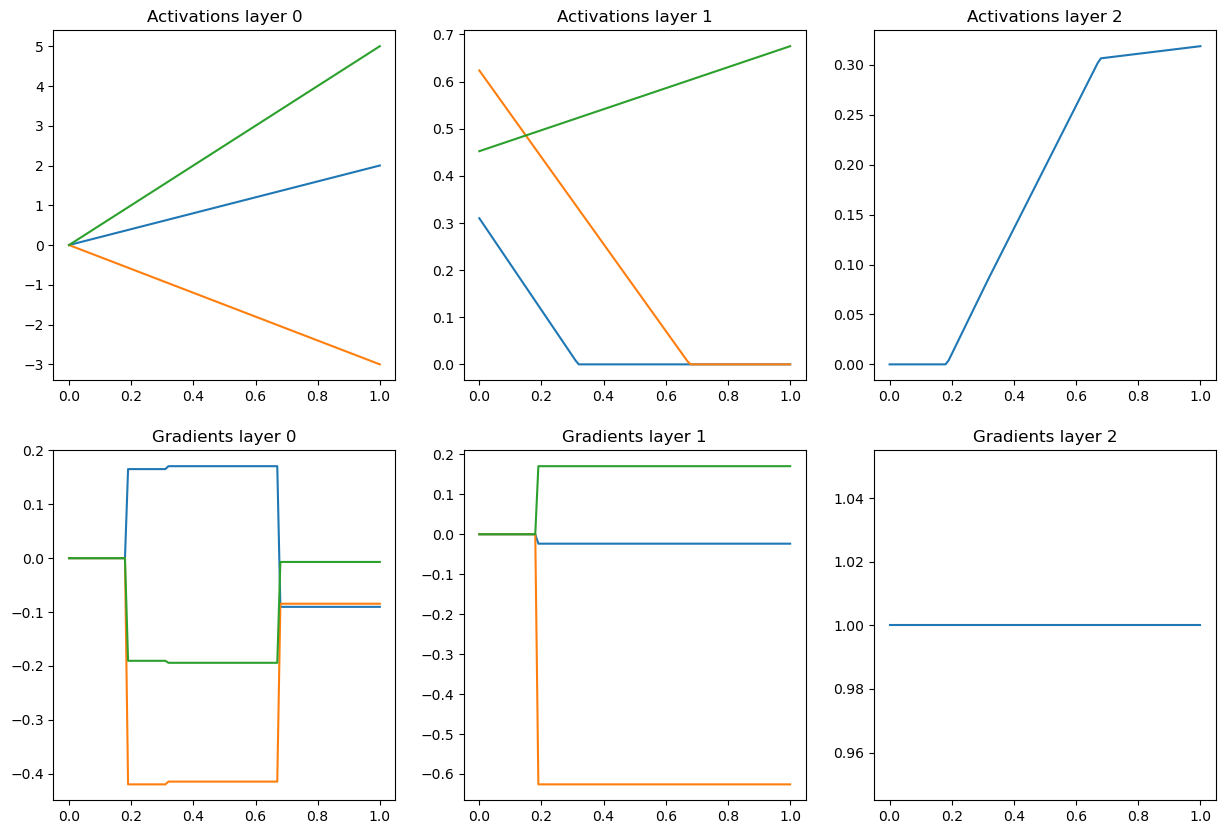

In [ ]:
m = ToyModel(inputs[0], outputs[0], hidden_sizes=[3], seed=2)

Activations = []
Gradients = []
T = np.linspace(0, 1, 101)

for t in T:
    m.zero_grad()  # Clear previous gradients
    m.forward(torch.tensor(t, requires_grad=True, dtype=torch.float)).backward(retain_graph=True)
    # Collect values
    Activations.append({ ind: d.detach().numpy() for ind, d in enumerate(m.activations)})
    Gradients.append({ ind: d.grad.detach().numpy() for ind, d in enumerate(m.activations)})

# Plot activations
n_plots = len(Activations[0])
fig, axs = plt.subplots(2, n_plots, figsize=(5*n_plots, 10))
for name, df, ax_row in zip(['Activations', 'Gradients'], [pd.DataFrame(Activations), pd.DataFrame(Gradients)], axs):
    for ax, col in zip(ax_row, df.columns):
        arr = np.array(df[col].to_list())
        ax.plot(T, arr)
        ax.set_title(f"{name} layer {col}")

plt.show()

# Captum on MNIST model

In [5]:
model_dict = load_mnist_v4_models()
model_d3 = model_dict['cb1-8-8-8_cb2-16-16-16_seed-0']
data, target = first_mnist_batch(batch_size=10)

In [ ]:
# import gauss_legendre_builders from captum:
from captum.attr._utils.approximation_methods import gauss_legendre_builders
from captum.attr._utils.common import _format_input_baseline
from captum.attr import IntegratedGradients

In [ ]:
step_sizes, alphas = gauss_legendre_builders()

In [ ]:
from captum._utils.common import (
    _expand_additional_forward_args,
    _expand_target,
    _format_additional_forward_args,
    _format_output,
    _is_tuple
)
from captum.attr._utils.common import (
    _format_input_baseline,
    _reshape_and_sum,
    _validate_input,
)
from captum.attr._utils.approximation_methods import approximation_parameters

In [ ]:


n = 1000
selected = [0,1,5,10,50,-51,-11,-6,-2,-1]
i_image = 2

ig_data = data[i_image:i_image+1].repeat(n,1,1,1)
ig_target = target[i_image:i_image+1].repeat(n)
ig_baseline = ig_data.detach().clone() * torch.linspace(0, 1, n).flip(0).reshape(n,1,1,1)

ig_data = ig_data[selected]
ig_target = ig_target[selected]
ig_baseline = ig_baseline[selected]

# applying integrated gradients on the SoftmaxModel and input data point
ig = IntegratedGradients(model_d3)
attributions, approximation_error = ig.attribute(ig_data, baselines=ig_baseline, target=ig_target,
                                    return_convergence_delta=True)

attributions = attributions.clone().detach().numpy()[:, 0]

# attributions, \
approximation_error

tensor([ 0.0000e+00, -1.1061e-06,  2.6093e-06, -8.5099e-06,  2.4429e-05,
        -1.0793e-02, -8.7737e-02,  1.3324e-01, -1.0204e-01,  1.5498e-02],
       dtype=torch.float64)

# My IG implementation

In [80]:
del IntermediateIntegratedGradients

In [3]:
from util.ig import *
from util.oig import *

In [6]:
oiig = OIntermediateIntegratedGradients(model_d3.seq)
# gs = oiig.batch_attribute(data[:2], measure_at_layers=d3_before_all_conv, like_lrp=True, multiply_by_inputs=False)
oigs = oiig.batch_attribute(data[:2], measure_at_layers=d3_before_all_conv, like_lrp=True, multiply_by_inputs=True, n_steps=13, baselines_at_steps=1)

In [7]:
iig = IntermediateIntegratedGradients(model_d3.seq)
# gs = iig.batch_attribute(data[:2], measure_at_layers=d3_before_all_conv, like_lrp=True, multiply_by_inputs=False)
igs = iig.batch_attribute(data[:2], measure_at_layers=d3_before_all_conv, like_lrp='mask', multiply_by_inputs=True, n_steps=13, baselines_at_steps=1)

like_lrp mask
like_lrp mask
grads_list 2 10 7 (1, 784)
(1, 784)
(2, 10, 1, 784)
(2, 1, 10, 784)

(1, 6272)
(2, 10, 1, 6272)
(2, 1, 10, 6272)

(1, 6272)
(2, 10, 1, 6272)
(2, 1, 10, 6272)

(1, 1152)
(2, 10, 1, 1152)
(2, 1, 10, 1152)

(1, 1024)
(2, 10, 1, 1024)
(2, 1, 10, 1024)

(1, 1024)
(2, 10, 1, 1024)
(2, 1, 10, 1024)

(1, 256)
(2, 10, 1, 256)
(2, 1, 10, 256)



/Users/johannes/Applications/miniconda3/envs/msc/lib/python3.10/site-packages/torch/autograd/__init__.py:197: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646991213/work/torch/csrc/autograd/engine.cpp:1064.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [115]:
len(igs), igs[0].shape

(7, (2, 1, 10, 784))

In [ ]:
len(igs), igs[0].shape

(7, (2, 1, 10, 784))

In [127]:
for i,o in zip(igs, oigs):
    print(i.shape, o.shape)
    if not (np.allclose(i,o)):
        # print((np.abs(i-o).sum(axis=3) / np.clip(np.abs(i).sum(axis=3), 0.1, 1e9)).astype(float))

        print('i-o', np.abs(i-o).sum(axis=3).astype(int).flatten())
        print('i  ', np.abs(i).sum(axis=3).astype(int).flatten())
        print('o  ', np.abs(o).sum(axis=3).astype(int).flatten())

(2, 1, 10, 784) (2, 1, 10, 784)
i-o [0 0 0 5 0 0 0 0 9 8 0 0 0 0 1 0 0 3 0 0]
i   [ 0  0  4  6  0  0  0  0  8 28  0  1  0  0  4  0  0  5  0  0]
o   [ 0  0  4  8  0  0  0  0  1 30  0  1  0  0  6  0  0  3  0  0]
(2, 1, 10, 6272) (2, 1, 10, 6272)
i-o [ 0  0  0  6  0  0  0  0 11  9  0  0  0  0  1  0  0  4  0  0]
i   [ 0  0  5  7  0  0  0  0  9 35  0  1  0  0  5  0  0  5  0  0]
o   [ 0  0  5  9  0  0  0  0  2 36  0  1  0  0  6  0  0  4  0  0]
(2, 1, 10, 6272) (2, 1, 10, 6272)
i-o [ 0  0  0  7  0  0  0  0 12 10  0  0  0  0  1  0  0  5  0  0]
i   [ 0  0  5  8  0  0  0  0 10 42  0  1  0  0  6  0  0  6  0  0]
o   [ 0  0  5 11  0  0  0  0  2 44  0  1  0  0  7  0  0  5  0  0]
(2, 1, 10, 1152) (2, 1, 10, 1152)
i-o [ 0  0  0  8  0  0  0  0 14 11  0  0  0  0  1  0  0  7  0  0]
i   [ 0  0  6  9  0  0  0  0 12 48  0  1  0  0  7  0  0  7  0  0]
o   [ 0  0  6 13  0  0  0  0  3 50  0  1  0  0  8  0  0  7  0  0]
(2, 1, 10, 1024) (2, 1, 10, 1024)
i-o [ 0  0  0  8  0  0  0  0 13 11  0  0  0  0  2  0  0 13  

## Run on VGG

In [5]:
cat16 = load_cat16()
model = torchvision.models.vgg16(pretrained=True); model.eval()

/Users/johannes/Applications/miniconda3/envs/msc/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/johannes/Applications/miniconda3/envs/msc/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
class FlattenExceptBatch(nn.Module):
    def forward(self, x):
        batch_size = x.size(0)
        return x.view(batch_size, -1)

vgg_layers = list(model.features) + [model.avgpool, FlattenExceptBatch()] + list(model.classifier)

vgg_linear_layer_idx = []
for i, layer in enumerate(vgg_layers):
    n = layer.__class__.__name__
    if n in ['Conv2d',
            #  'MaxPool2d', 'AvgPool2d',
             'Linear']:
        vgg_linear_layer_idx.append(i)
        
        print('=', i, layer)
    else:
        print(' ', i, layer)


= 0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  1 ReLU(inplace=True)
= 2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  3 ReLU(inplace=True)
  4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
= 5 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  6 ReLU(inplace=True)
= 7 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  8 ReLU(inplace=True)
  9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
= 10 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  11 ReLU(inplace=True)
= 12 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  13 ReLU(inplace=True)
= 14 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  15 ReLU(inplace=True)
  16 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
= 17 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  18 ReLU(inplace=True)


In [8]:
iig = IntermediateIntegratedGradients(vgg_layers)
grads = iig.batch_attribute(cat16, measure_at_layers=vgg_linear_layer_idx, like_lrp=True, multiply_by_inputs=False)
# grads = iig.batch_attribute(cat16, measure_at_layers=vgg_linear_layer_idx, like_lrp=True, multiply_by_inputs=False)
# i_grads = iig.batch_attribute(cat16[:1], measure_at_layers=vgg_linear_layer_idx, like_lrp=True, multiply_by_inputs=True, n_steps=100, baselines_at_steps=[100])

print(len(grads), grads[0].shape)
print(type(grads), type(grads[0]), type(grads[0][0]), type(grads[0][0][0]), type(grads[0][0][0][0]))

16 (16, 1, 10, 150528)
<class 'list'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


### Svals

In [9]:
svals_grads = calc_vals_batch(grads, num_vals='auto', tqdm_for='point', return_vecs=False)
# svals_i_grads = calc_vals_batch(i_grads, num_vals='auto', tqdm_for='point', return_vecs=False)

print(svals_grads.shape)
print(svals_i_grads.shape)

16it [00:02,  7.55it/s]
16it [00:34,  2.16s/it]
16it [00:05,  2.90it/s]
16it [00:15,  1.06it/s]
16it [00:02,  6.76it/s]
16it [00:05,  3.18it/s]
16it [00:05,  3.10it/s]
16it [00:01, 13.41it/s]
16it [00:03,  4.94it/s]
16it [00:02,  6.70it/s]
16it [00:00, 25.20it/s]
16it [00:00, 28.38it/s]
16it [00:00, 24.72it/s]
16it [00:00, 130.55it/s]
16it [00:00, 337.92it/s]
16it [00:00, 490.41it/s]


(16, 16, 1, 6)


NameError: name 'svals_i_grads' is not defined

## Condition number of increasing subsections of the backward pass

#### Gradient

In [11]:
svals_grads.shape

(16, 16, 1, 6)

In [30]:
mask0 = ((svals_grads != 0).sum(axis=(3), keepdims=True) != 0) * np.ones_like(svals_grads, dtype=bool)
mask0.shape

(16, 16, 1, 6)

lines


<Figure size 640x480 with 0 Axes>

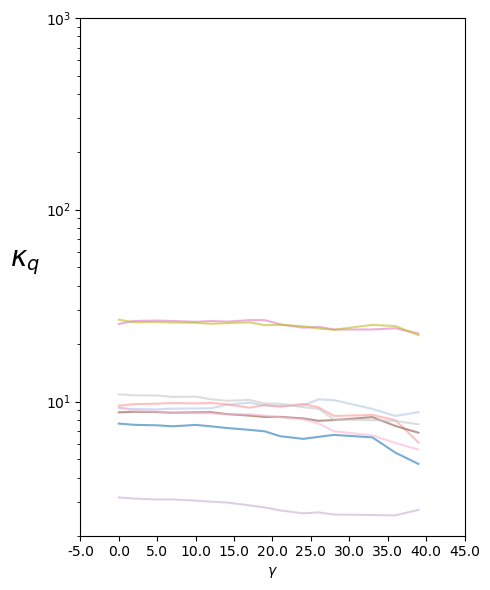

In [32]:
mask0 = ((svals_grads != 0).sum(axis=(3), keepdims=True) != 0) * np.ones_like(svals_grads, dtype=bool)
mask0 = ((svals_grads != 0).sum(axis=(0,2,3)) != 0)
vals = svals_grads[:, mask0].transpose((2,1,0,3))
g = vgg_linear_layer_idx

fig, axs = plot_condition_number(vals, g, ylim=(2, 1e3), sharey=True, mode='lines', xlim=(min(g), max(g)), xscale='linear')
# annotate_axs_d3_individual_gamma(axs, n_expected=5, left=True)

### Relevance Preservation

In [33]:
# col_sums_i_grads     = np.array([        for_one_matrix.sum(axis=-1) for for_one_matrix in i_grads])
# col_sums_i_grads_abs = np.array([np.abs(for_one_matrix).sum(axis=-1) for for_one_matrix in i_grads])

col_sums_grads     = np.array([        for_one_matrix.sum(axis=-1) for for_one_matrix in grads])
col_sums_grads_abs = np.array([np.abs(for_one_matrix).sum(axis=-1) for for_one_matrix in grads])

n_weights, n_points, n_configs, n_vals = col_sums_grads_abs.shape
# assert col_sums_i_grads_abs.shape == col_sums_grads_abs.shape, "Following reshapes are based on this assumption."
print(n_weights, n_points, n_configs, n_vals)

16 16 1 10


#### IG

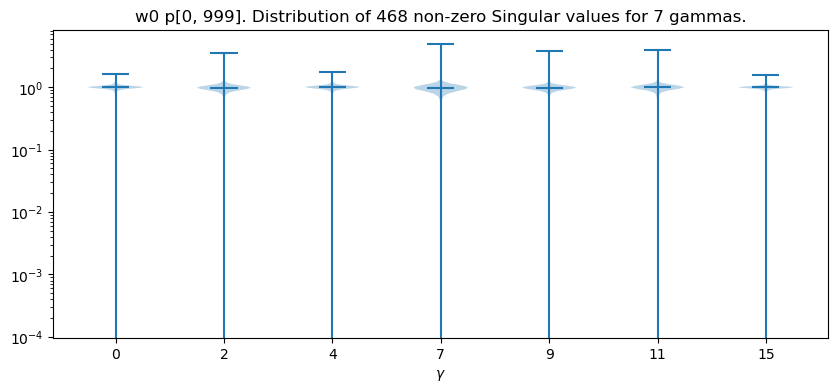

In [ ]:
v = col_sums_i_grads.transpose((2,1,3,0)).reshape((n_configs, n_points*n_vals, n_weights, 1))
fig, axs = distribution_plot(v, gammas=d3_before_all_conv, \
                  aggregate_over='points', mode='violin', cutoff=4e-4, xscale='arange', showextrema=True, showmedians=True)

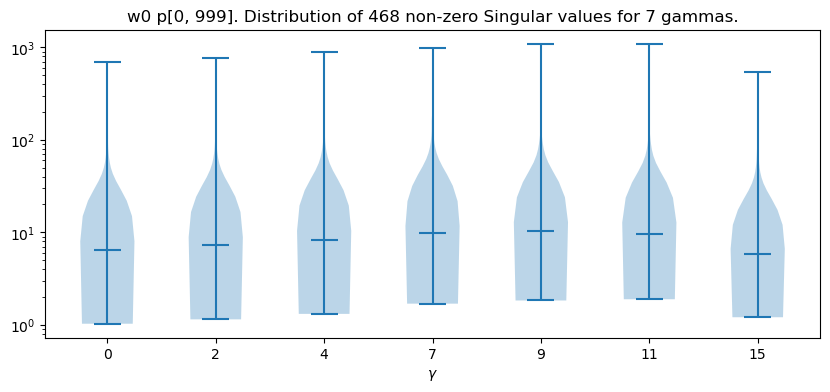

In [ ]:
v = col_sums_i_grads_abs.transpose((2,1,3,0)).reshape((n_configs, n_points*n_vals, n_weights, 1))
fig, axs = distribution_plot(v, gammas=d3_before_all_conv, \
                  aggregate_over='points', mode='violin', cutoff=4e-4, xscale='arange', showextrema=True, showmedians=True)

#### Grads

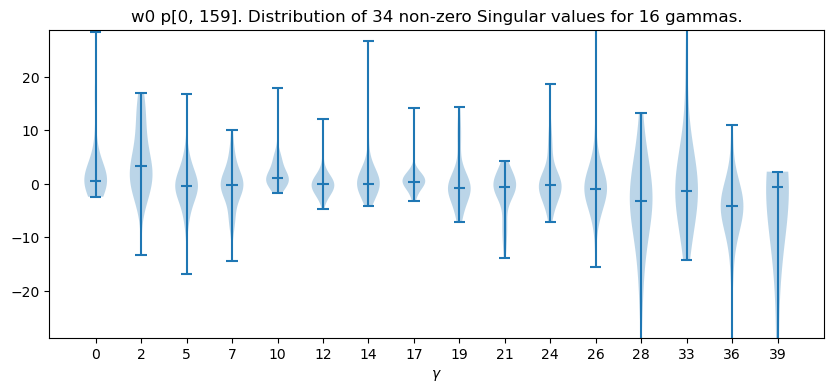

In [35]:
v = col_sums_grads.transpose((2,1,3,0)).reshape((n_configs, n_points*n_vals, n_weights, 1))
fig, axs = distribution_plot(v, gammas=vgg_linear_layer_idx, \
                  aggregate_over='points', mode='violin', cutoff=4e-4, xscale='arange', showextrema=True, showmedians=True)

for axr in axs:
    maxi = np.percentile(np.abs(col_sums_grads), 99.7)
    for ax in axr:
        ax.set_yscale('linear')
        ax.set_ylim(-maxi, maxi)

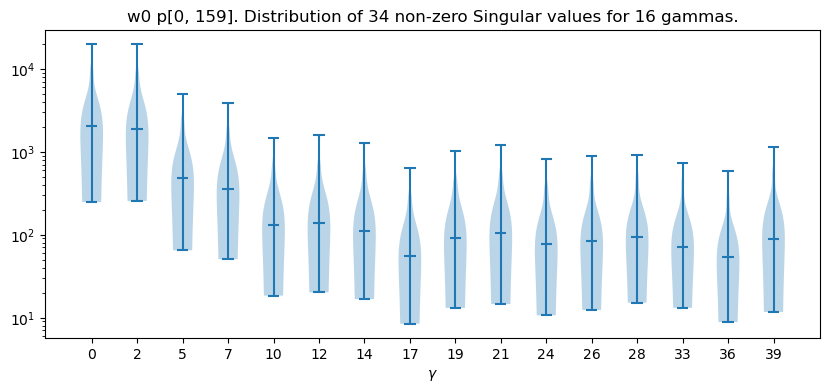

In [36]:
v = col_sums_grads_abs.transpose((2,1,3,0)).reshape((n_configs, n_points*n_vals, n_weights, 1))
fig, axs = distribution_plot(v, gammas=vgg_linear_layer_idx, \
                  aggregate_over='points', mode='violin', cutoff=4e-4, xscale='arange', showextrema=True, showmedians=True)

## MNIST

In [ ]:
n_points = 100

iig = IntermediateIntegratedGradients(model_d3.seq)
grads = iig.batch_attribute(data[:n_points], measure_at_layers=d3_before_all_conv, like_lrp=True, multiply_by_inputs=False)
i_grads = iig.batch_attribute(data[:n_points], measure_at_layers=d3_before_all_conv, like_lrp=True, multiply_by_inputs=True, n_steps=100, baselines_at_steps=[100])

print(len(grads), grads[0].shape)
print(type(grads), type(grads[0]), type(grads[0][0]), type(grads[0][0][0]), type(grads[0][0][0][0]))

7 (100, 1, 10, 784)
<class 'list'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


## Svals

In [56]:
svals_grads = calc_vals_batch(grads, num_vals='auto', tqdm_for='point', return_vecs=False)
svals_i_grads = calc_vals_batch(i_grads, num_vals='auto', tqdm_for='point', return_vecs=False)

print(svals_grads.shape, svals_i_grads.shape)

100it [00:00, 1840.74it/s]
100it [00:00, 379.12it/s]
100it [00:00, 590.58it/s]
100it [00:00, 365.89it/s]
100it [00:00, 1936.15it/s]
100it [00:00, 375.31it/s]
100it [00:00, 757.49it/s]
100it [00:00, 3214.10it/s]
100it [00:00, 262.38it/s]
100it [00:00, 398.87it/s]
100it [00:00, 1706.75it/s]
100it [00:00, 2102.70it/s]
100it [00:00, 467.61it/s]
100it [00:00, 1749.81it/s]

(7, 100, 1, 7) (7, 100, 1, 7)


In [57]:
ylim = (1,1000)

d = condition_number(svals_i_grads, percentile=.95)
print(d.shape)

(7, 100, 1)


(6, 100)


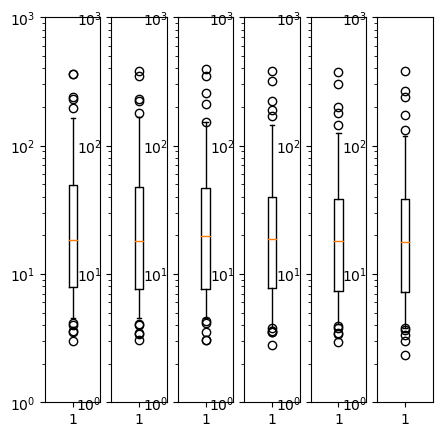

In [25]:
ylim = (1,1000)

d = condition_number(svals_grads, percentile=.95)[:, :, 0]
print(d.shape)
# boxplot vertical, log scaled y axis:
fig, axs = plt.subplots(1, len(d), figsize=(5, 5))
for ax, d in zip(axs, d):    
    ax.set_yscale('log')
    ax.boxplot(d, vert=True, showfliers=True, whis=[5, 95])
    ax.set_ylim(ylim)

## Check validity of generated matrics

Column sums to check preservation

In [81]:
grads[0].shape

(100, 1, 10, 784)

In [84]:
grads[0][0,0].sum(axis=1)

array([ 0.        ,  0.        ,  0.18694109,  1.8460118 ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.7210126 , -4.4623237 ],
      dtype=float32)

In [97]:
for g in i_grads:
    for p in g[:8]:
        for sum in p[0].sum(axis=1):
            print(f"{sum:5.2f} " if sum else '.', end='')
        print(' | ', end='')
    print()


.. 0.99  1.00 .... 1.00  1.12  | . 0.98 .. 1.16 .. 0.98 .. | ... 1.01  1.02  0.81 . 1.02  0.96  1.01  | ... 1.10  1.03  0.99 . 1.01 . 1.01  | .. 0.98  1.00 .... 1.00  1.03  |  1.00 .... 1.00  1.01 . 1.01  0.96  | .. 1.00  1.02  1.48 .. 0.91  1.01 . | .. 1.00  0.98 ... 0.99  0.05 . | 
.. 0.98  0.95 .... 0.98  1.05  | . 0.98 .. 1.13 .. 1.00 .. | ... 0.94  0.99  0.56 . 1.02  1.00  0.99  | ...-0.51  1.00  0.97 . 1.01 . 1.00  | .. 0.97  1.00 .... 0.99  1.04  |  1.02 .... 0.98  1.00 . 1.00  0.73  | .. 0.98  0.99  1.44 .. 1.16  0.94 . | .. 0.95  0.94 ... 0.95  0.66 . | 
.. 0.99  1.02 .... 1.01  1.00  | . 0.98 .. 1.13 .. 0.99 .. | ... 0.99  1.02  0.69 . 1.02  1.04  1.01  | ... 0.83  1.02  0.98 . 1.02 . 1.02  | .. 0.98  1.01 .... 1.01  1.02  |  1.01 .... 1.00  1.02 . 1.01  0.95  | .. 1.00  1.03  1.35 .. 1.05  1.01 . | .. 0.99  0.98 ... 1.00 -0.01 . | 
.. 0.96  1.05 .... 0.99  1.06  | . 0.95 .. 1.09 .. 0.99 .. | ... 0.90  1.08  0.50 . 1.01  0.82  0.99  | ... 0.13  1.09  0.91 . 0.98 . 1.00  | .. 

In [96]:
for g in i_grads:
    for p in g[:8]:
        for sum in np.abs(p[0]).sum(axis=1):
            print(f"{sum:5.2f} " if sum else '.', end='')
        print(' | ', end='')
    print()


.. 4.48  8.47 .... 1.97 29.90  | . 1.03 .. 6.04 .. 3.79 .. | ...14.01  6.15 40.49 . 7.93 34.74  1.80  | ...172.78  4.54  5.43 . 3.54 . 1.56  | .. 6.12  5.03 .... 1.48 14.85  |  4.74 .... 2.22  1.42 . 2.45 34.22  | .. 1.43  5.14 73.87 ..24.95 10.24 . | .. 3.12  9.89 ... 5.01 239.85 . | 
.. 5.01  9.41 .... 2.28 34.92  | . 1.14 .. 6.57 .. 4.65 .. | ...14.84  6.72 44.46 . 8.38 37.47  2.03  | ...191.37  5.39  6.04 . 4.13 . 1.77  | .. 6.78  5.61 .... 1.67 16.80  |  5.20 .... 2.37  1.65 . 2.76 38.32  | .. 1.68  5.89 79.74 ..30.37 11.49 . | .. 3.42 10.21 ... 5.56 260.87 . | 
.. 5.69 10.93 .... 2.66 42.44  | . 1.31 .. 7.40 .. 5.61 .. | ...17.40  7.55 53.59 . 9.59 43.83  2.41  | ...222.36  6.39  6.88 . 4.64 . 2.06  | .. 7.84  6.63 .... 1.96 18.47  |  5.91 .... 2.63  1.89 . 3.09 42.62  | .. 1.99  7.12 90.78 ..35.87 13.62 . | .. 4.10 11.94 ... 6.53 310.77 . | 
.. 6.35 13.00 .... 3.19 49.53  | . 1.69 .. 8.23 .. 7.72 .. | ...20.75  7.34 66.29 . 9.80 49.93  2.86  | ...252.86  7.36  7.85 . 5.67 . 2.54

### Violin plot (across all classes)

In [139]:
col_sums_i_grads     = np.array([        for_one_matrix.sum(axis=-1) for for_one_matrix in i_grads])
col_sums_i_grads_abs = np.array([np.abs(for_one_matrix).sum(axis=-1) for for_one_matrix in i_grads])

col_sums_grads     = np.array([        for_one_matrix.sum(axis=-1) for for_one_matrix in grads])
col_sums_grads_abs = np.array([np.abs(for_one_matrix).sum(axis=-1) for for_one_matrix in grads])

n_weights, n_points, n_configs, n_vals = col_sums_i_grads_abs.shape
assert col_sums_i_grads_abs.shape == col_sums_grads_abs.shape, "Following reshapes are based on this assumption."
print(n_weights, n_points, n_configs, n_vals)

7 100 1 10


#### IG

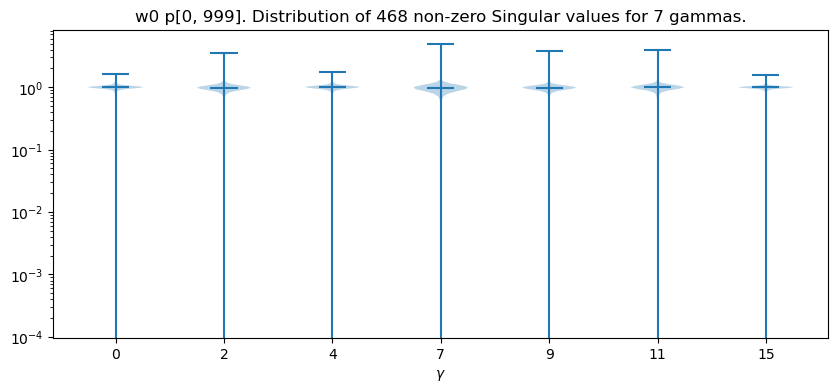

In [135]:
v = col_sums_i_grads.transpose((2,1,3,0)).reshape((n_configs, n_points*n_vals, n_weights, 1))
fig, axs = distribution_plot(v, gammas=d3_before_all_conv, \
                  aggregate_over='points', mode='violin', cutoff=4e-4, xscale='arange', showextrema=True, showmedians=True)

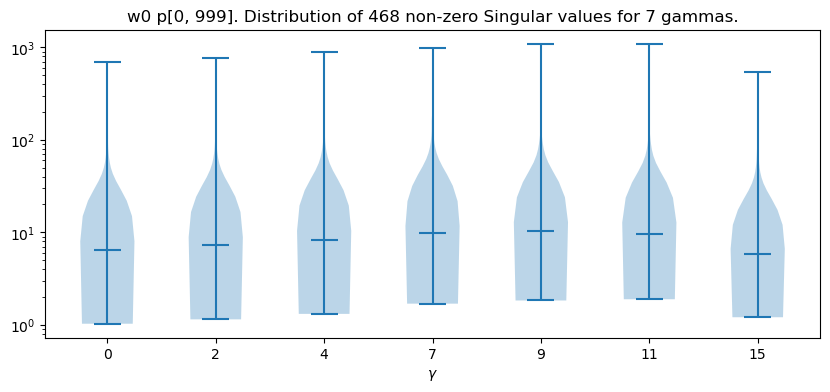

In [ ]:
v = col_sums_i_grads_abs.transpose((2,1,3,0)).reshape((n_configs, n_points*n_vals, n_weights, 1))
fig, axs = distribution_plot(v, gammas=d3_before_all_conv, \
                  aggregate_over='points', mode='violin', cutoff=4e-4, xscale='arange', showextrema=True, showmedians=True)

#### Grads

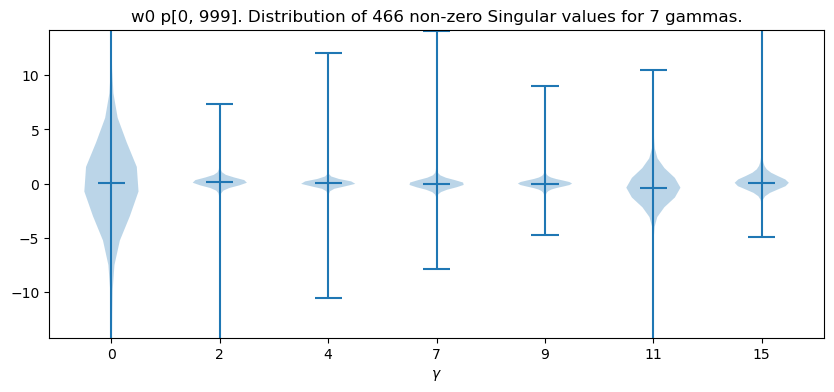

In [155]:
v = col_sums_grads.transpose((2,1,3,0)).reshape((n_configs, n_points*n_vals, n_weights, 1))
fig, axs = distribution_plot(v, gammas=d3_before_all_conv, \
                  aggregate_over='points', mode='violin', cutoff=4e-4, xscale='arange', showextrema=True, showmedians=True)

for axr in axs:
    maxi = np.percentile(np.abs(col_sums_grads), 99.7)
    for ax in axr:
        ax.set_yscale('linear')
        ax.set_ylim(-maxi, maxi)

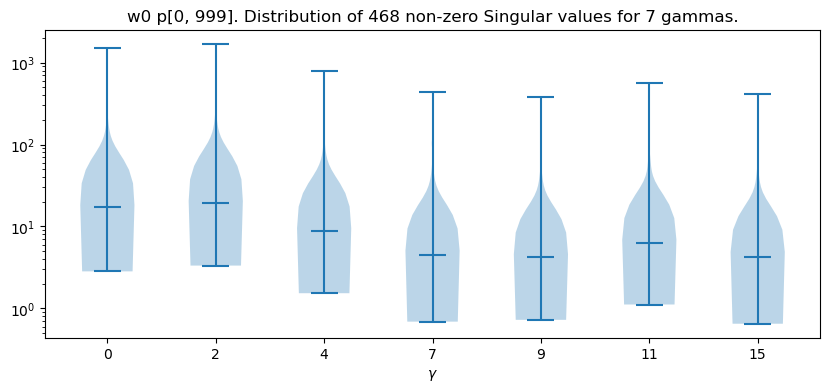

In [156]:
v = col_sums_grads_abs.transpose((2,1,3,0)).reshape((n_configs, n_points*n_vals, n_weights, 1))
fig, axs = distribution_plot(v, gammas=d3_before_all_conv, \
                  aggregate_over='points', mode='violin', cutoff=4e-4, xscale='arange', showextrema=True, showmedians=True)

#### Violin plot (per class)

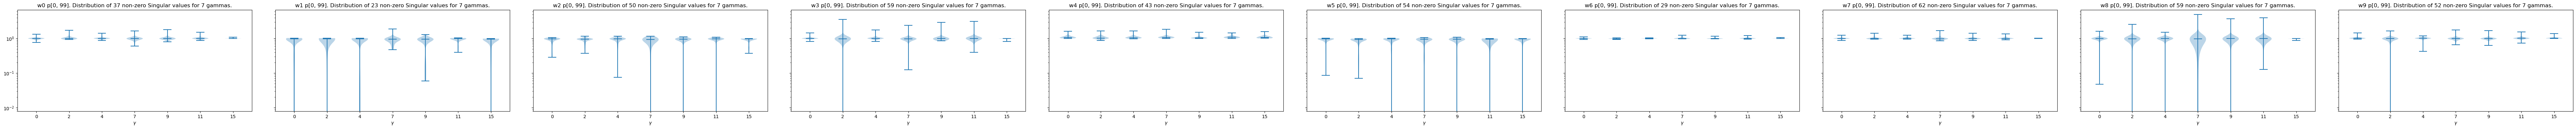

In [138]:
v = col_sums_i_grads.transpose((3,1,2,0)).reshape((n_vals, n_points, n_weights, n_configs))
fig, axs = distribution_plot(v, gammas=d3_before_all_conv, \
                  aggregate_over='points', mode='violin', cutoff=4e-4, xscale='arange', showextrema=True, showmedians=True, sharey=True)

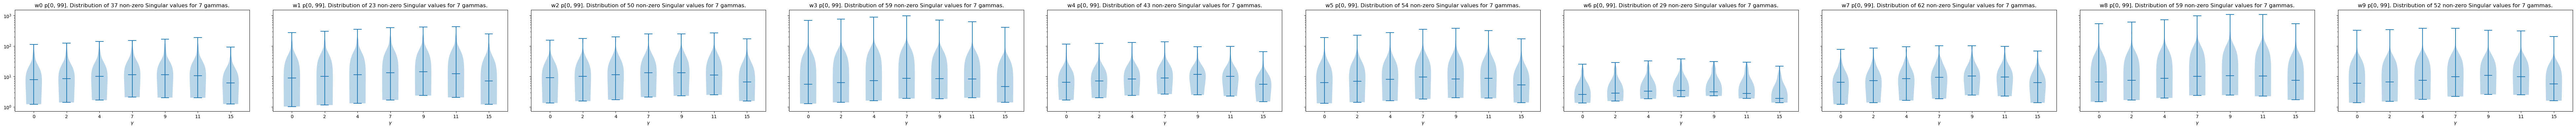

In [137]:
v = col_sums_i_grads_abs.transpose((3,1,2,0)).reshape((n_vals, n_points, n_weights, n_configs))
fig, axs = distribution_plot(v, gammas=d3_before_all_conv, \
                  aggregate_over='points', mode='violin', cutoff=4e-4, xscale='arange', showextrema=True, showmedians=True, sharey=True)

# Line plot

## Condition number of increasing subsections of the backward pass

#### Gradient

In [79]:
svals_grads.shape

(7, 100, 1, 7)

lines


<Figure size 640x480 with 0 Axes>

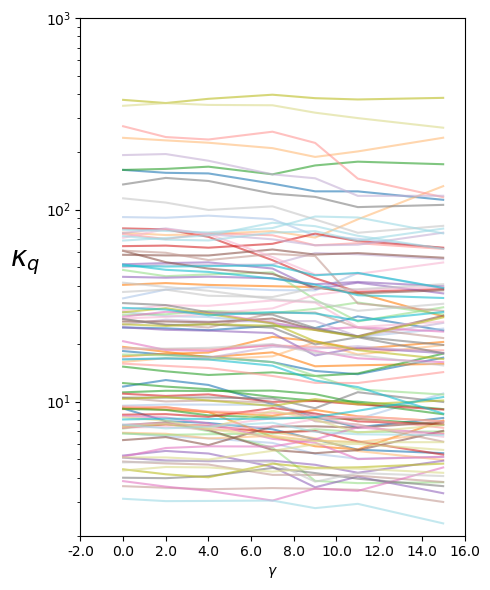

In [63]:
vals = svals_grads.transpose((2,1,0,3))

fig, axs = plot_condition_number(vals, d3_before_all_conv, ylim=(2, 1e3), sharey=True, mode='lines', xlim=(min(g), max(g)), xscale='linear')
# annotate_axs_d3_individual_gamma(axs, n_expected=5, left=True)

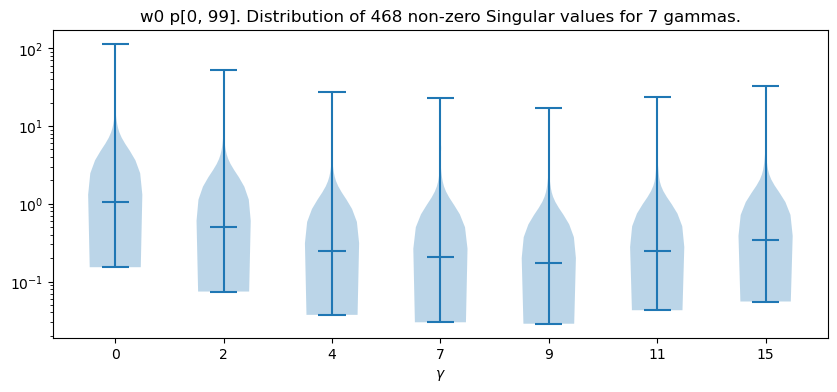

In [67]:
vals = svals_grads.transpose((2,1,0,3))
fig, axs = distribution_plot(vals, gammas=d3_before_all_conv, \
                  aggregate_over='points', mode='violin', cutoff=4e-4, xscale='arange', showextrema=True, showmedians=True)

#### IG

lines


<Figure size 640x480 with 0 Axes>

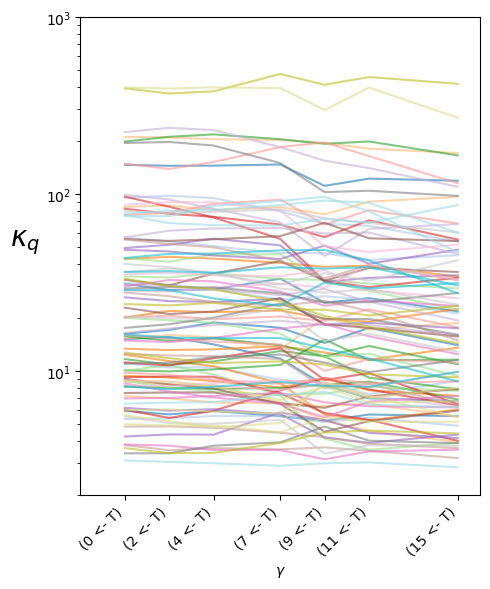

In [78]:
vals = svals_i_grads.transpose((2,1,0,3))

fig, axs = plot_condition_number(vals, d3_before_all_conv, ylim=(2, 1e3), sharey=True, mode='lines', xlim=(min(g), max(g)), xscale='linear')
# annotate_axs_d3_individual_gamma(axs, n_expected=5, left=True)
for ax in np.array(axs).flatten():
    ax.set_xticks(d3_before_all_conv)
    ax.set_xticklabels([f"({l} <- T)" for l in d3_before_all_conv], ha='right', rotation=45)

(1, 100, 7, 7)


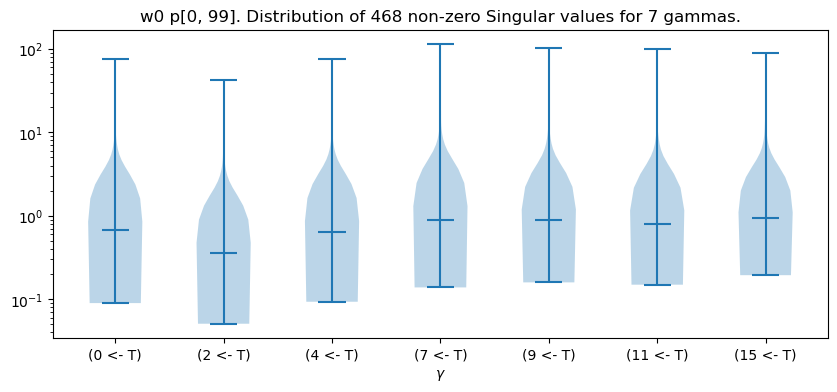

In [74]:
vals = svals_i_grads.transpose((2,1,0,3))
print(vals.shape)
fig, axs = distribution_plot(vals, gammas=d3_before_all_conv, \
                  aggregate_over='points', mode='violin', cutoff=4e-4, xscale='arange', showextrema=True, showmedians=True)

for ax in np.array(axs).flatten():
    ax.set_xticklabels([f"({l} <- T)" for l in d3_before_all_conv])

(1, 100, 6, 1) 6


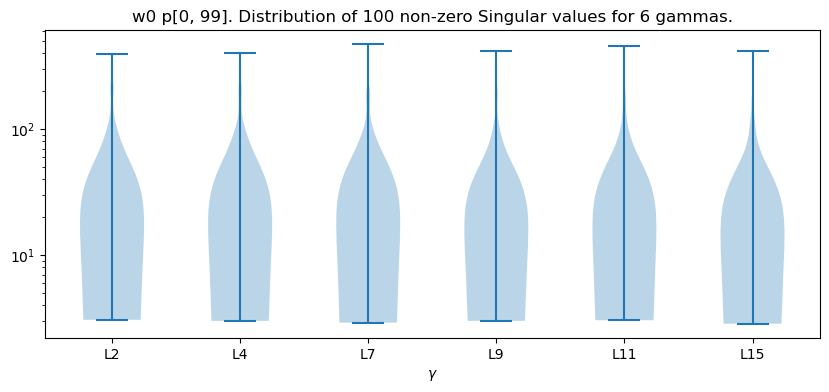

In [27]:
d = condition_number(svals_i_grads, percentile=.95)[:, :, :, None]
g = 1+np.arange(100)

# d = d[:, :, ::-20]
# g = g[::-20]
d = d[:, :, -1:]
g = g[-1:]

d = d.transpose((2,1,0,3))
g = [f'L{i-1}' for i in d3_after_conv_layer]

print(d.shape, len(g))

fig, axs = distribution_plot(d, gammas=g, \
                  aggregate_over='points', mode='violin', cutoff=4e-4, showmedians=False, xscale='arange')

In [87]:
svals__increasing_num_layers_backwards__gammas5 = load_data('d3', 'svals__increasing_num_layers_backwards__gammas5')
svals__increasing_num_layers_backwards__gammas5.shape

(5, 5, 5, 3201)

(5, 5, 5, 1) ['L4', 'L7', 'L9', 'L11', 'L15']


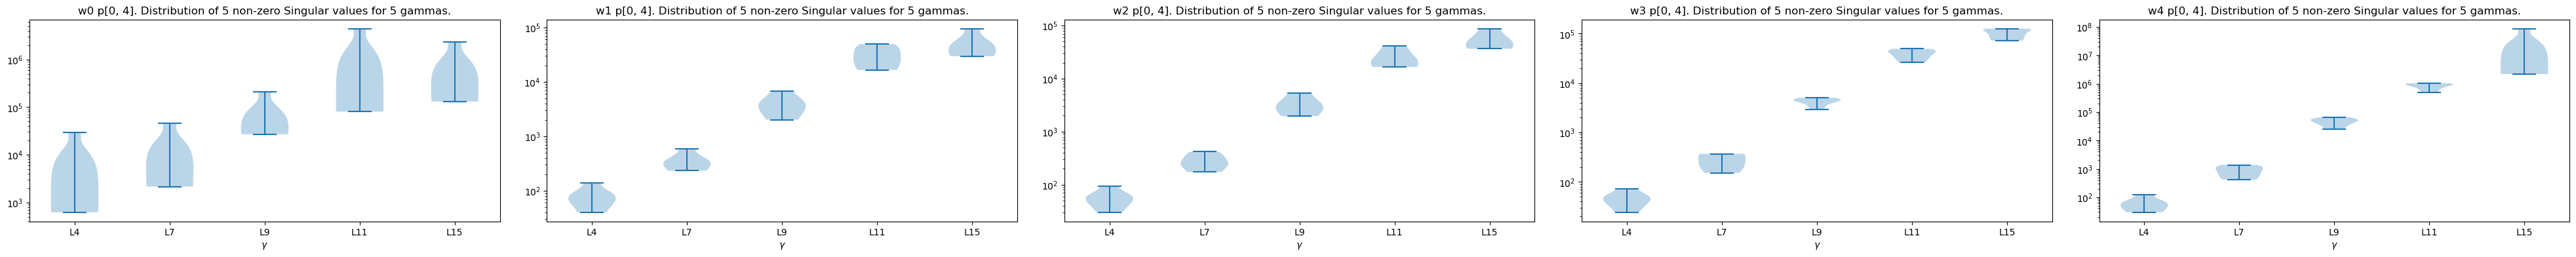

In [109]:
d = condition_number(svals__increasing_num_layers_backwards__gammas5, percentile=.95)[:, :, :, None]
g = gammas5

d = d.transpose((2,1,0,3))
g = [f'L{i-1}' for i in d3_after_conv_layer][1:]

print(d.shape, g)

fig, axs = distribution_plot(d, gammas=g, \
                  aggregate_over='points', mode='violin', cutoff=4e-4, showmedians=False, xscale='arange')

## Svecs

In [ ]:
# from output layer to layer 0
svals, lvecs, rvecs = calc_vals_batch(grads[:1], num_vals='auto', tqdm_for='point', return_vecs=True)

100it [00:00, 1399.60it/s]


In [ ]:
# from output layer to layer 1
svals_l1, lvecs_l1, rvecs_l1 = calc_vals_batch(grads[1:], num_vals='auto', tqdm_for='point', return_vecs=True)

100it [00:00, 476.13it/s]


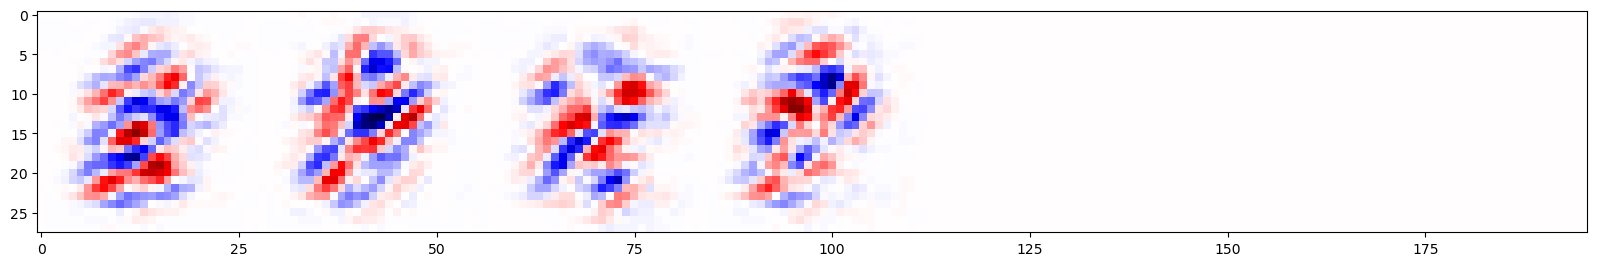

In [ ]:
my_rvecs = rvecs_l1.copy()

# which steps
my_steps = (0, 10, 50, -11, -1)
my_steps = (0,)

n_weights, n_points, n_steps, n_vals, shape_flattened = my_rvecs.shape
n_my_steps = len(my_steps)

data = my_rvecs[0,0,my_steps].reshape(n_my_steps, n_vals, -1, 28, 28).mean(axis=2).transpose((0, 2, 1, 3)).reshape(n_my_steps*28, n_vals*28)
maxi = np.max(np.abs(data))
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(data, vmin=-maxi, vmax=maxi, cmap='seismic')

## Svals with parameters

(<Figure size 2000x1000 with 1 Axes>,
 array([<AxesSubplot:xlabel='$\\gamma$', ylabel='Singular values'>],
       dtype=object))

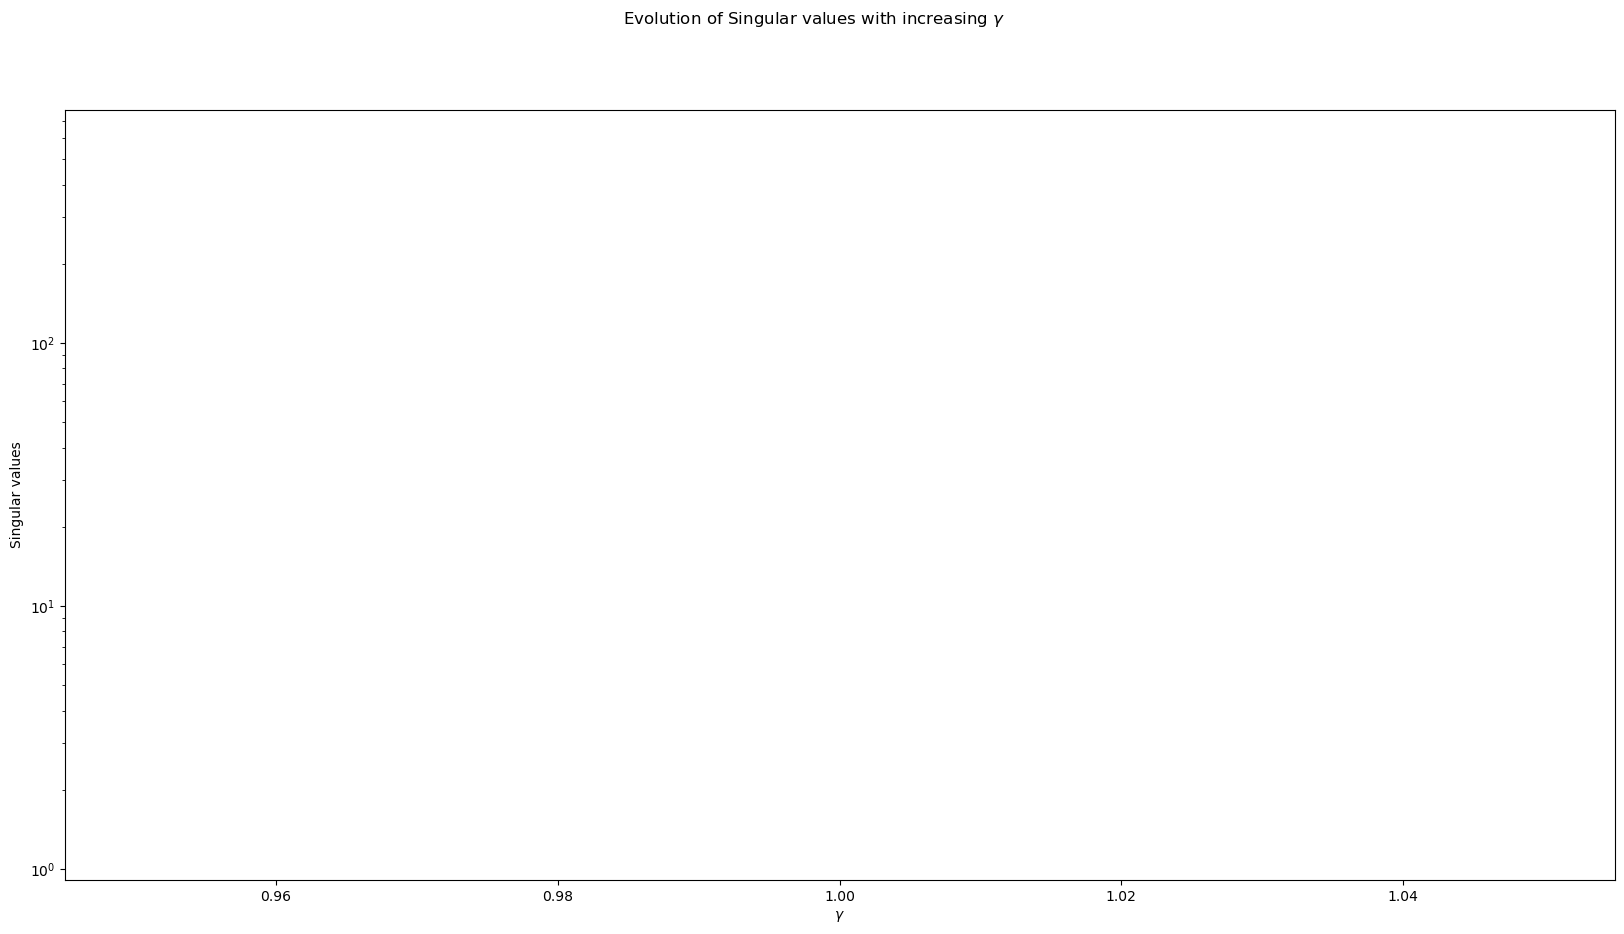

In [ ]:
vals = svals[:, :, :, :1] # / svals[:, :, :, :]
# vals -= vals[:, :, :1]

plot_vals_lineplot(vals, 1+np.arange(svals.shape[2]), ylim=(1,700), yscale='log', num_vals_total=200, colormap='seismic', one_plot_per='weight')

lines


(<Figure size 500x600 with 1 Axes>,
 [<AxesSubplot:xlabel='$\\gamma$', ylabel='$\\kappa_q$'>])

<Figure size 640x480 with 0 Axes>

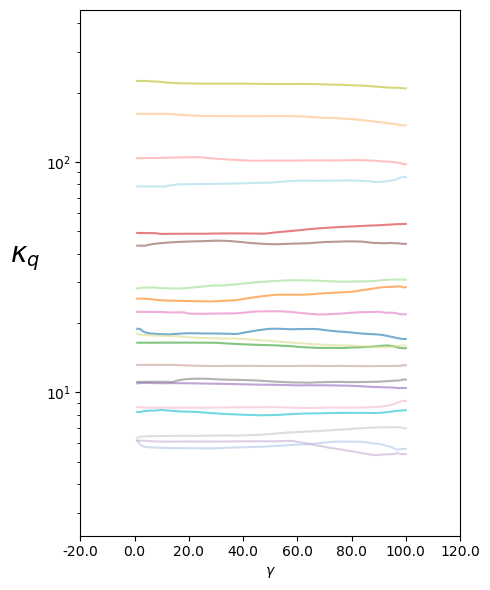

In [ ]:
plot_condition_number(svals_i_grads[1:, :20], gammas=1+np.arange(100), xscale='linear', xlim=(0,101), mode='lines', 
                      ylim=(2.3855244247560115, 456.5341774260212), yscale='log'
                    #   ylim=(-10,10), yscale='linear'
                      )

lines


(<Figure size 1000x600 with 2 Axes>,
 [<AxesSubplot:xlabel='$\\gamma$', ylabel='$\\kappa_q$'>,
  <AxesSubplot:xlabel='$\\gamma$'>])

<Figure size 640x480 with 0 Axes>

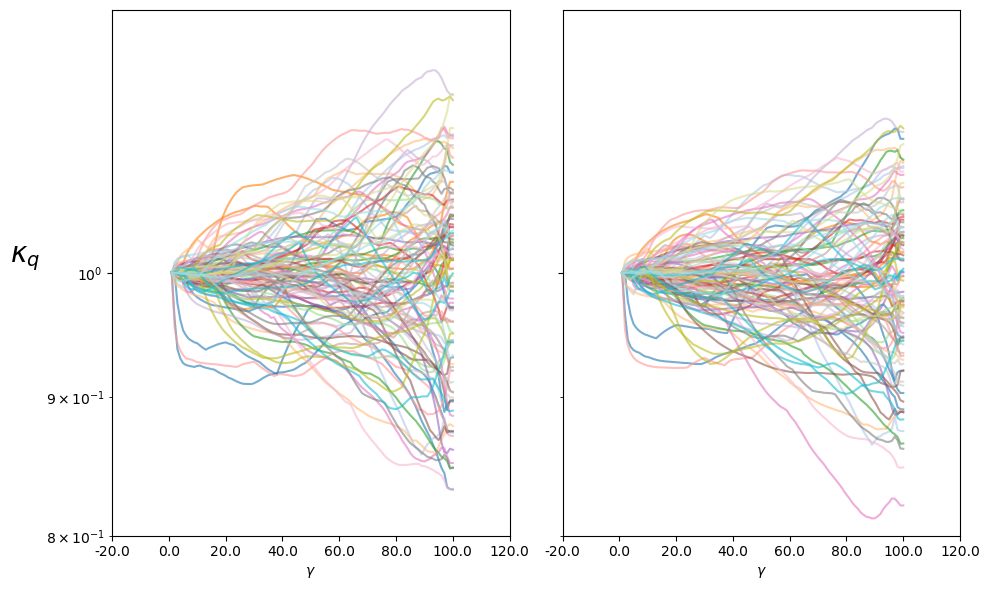

In [ ]:
plot_condition_number(svals, gammas=1+np.arange(100), xscale='linear', xlim=(0,101), mode='lines', 
                      ylim=(.8, 1.25), yscale='log'
                    #   ylim=(-10,10), yscale='linear'
                      )

/var/folders/lb/gcgcmyt11lq2rbpmsb109yfh0000gn/T/ipykernel_1042/3557728950.py:4: RuntimeWarning: divide by zero encountered in divide
  vals = svals[:, :, :, :1] / svals[:, :, :, :]


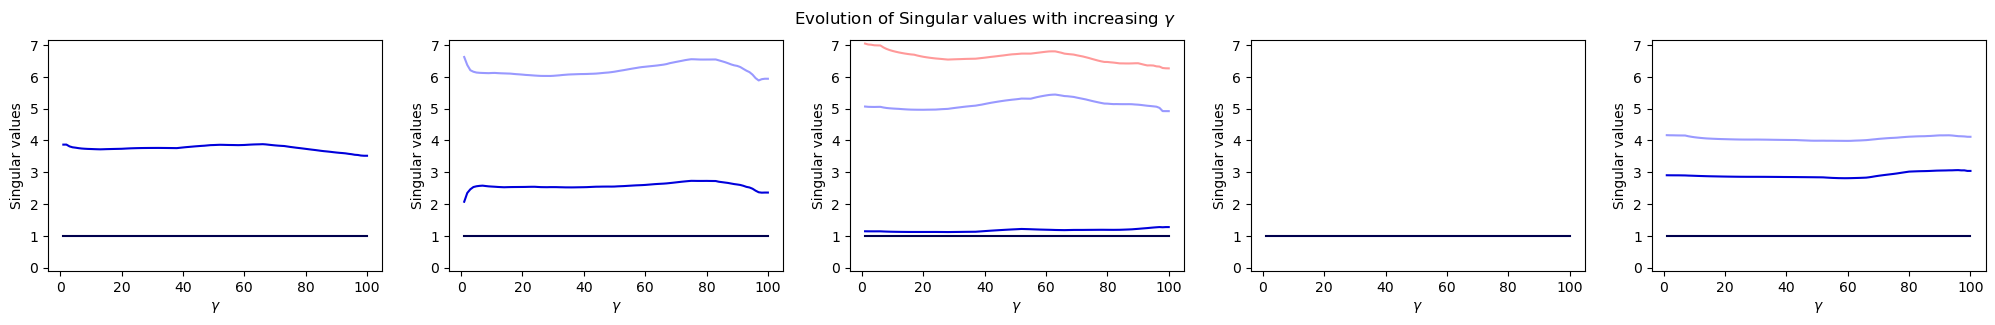

In [ ]:
from util.util_gamma_rule import plot_vals_lineplot

vals = svals
vals = svals[:, :, :, :1] / svals[:, :, :, :]

plot_vals_lineplot(vals, 1+np.arange(vals.shape[2]), ylim=(0,7), yscale='linear', num_vals_total=200, colormap='seismic', one_plot_per='point')

In [ ]:
np.array(grads_per_layer, dtype=object).shape

/var/folders/lb/gcgcmyt11lq2rbpmsb109yfh0000gn/T/ipykernel_63063/1363113278.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  np.array(grads_per_layer, dtype=object).shape


(2,)

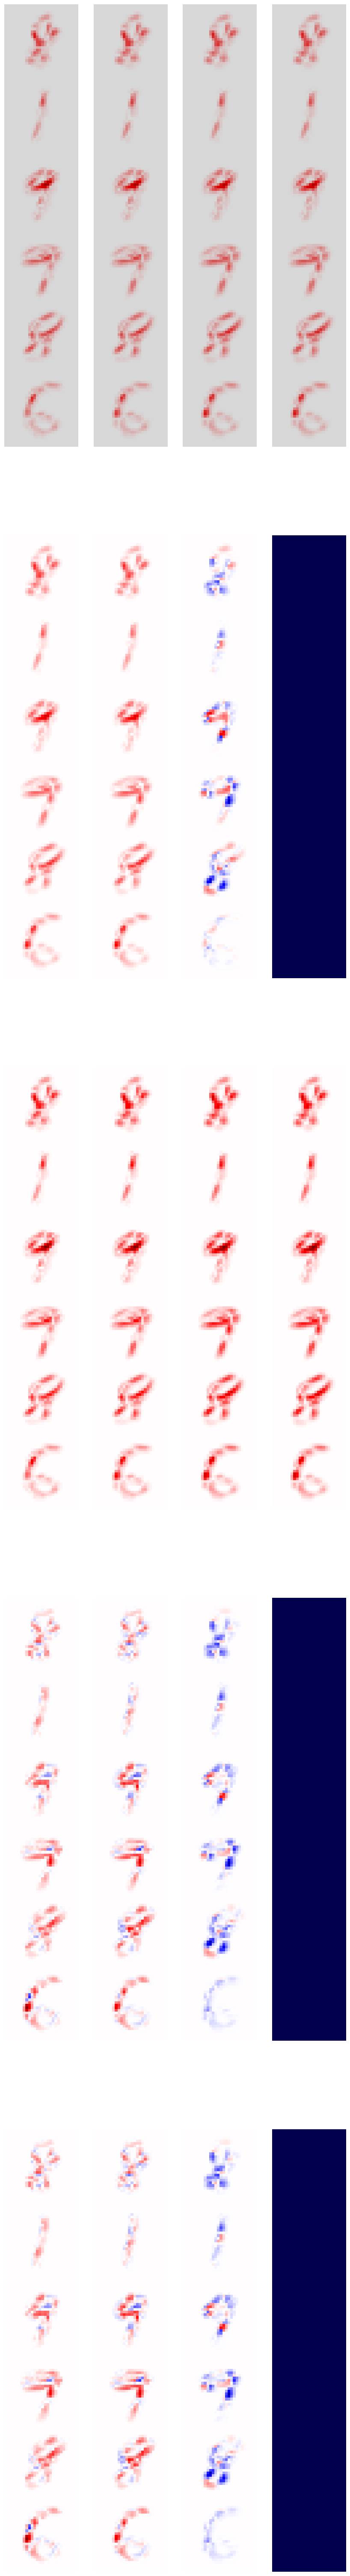

In [ ]:
R = attributions[-1]
b = 10*((np.abs(R)**3.0).mean()**(1.0/3))

n_rows=5
scale=2

fig, axs = plt.subplots(n_rows, len(attributions), figsize=(len(attributions)*scale, n_rows*len(attributions[0])*scale))
plt.subplots_adjust(left=0,right=1,bottom=0,top=1)

width = R.shape[-1]

for ax, R in zip(axs[0], attributions):
    b = 10*((np.abs(R)**3.0).mean()**(1.0/3))
    R = R.reshape(-1,width)
    ax.imshow(R,cmap=my_cmap,vmin=-b,vmax=b,interpolation='nearest')
    ax.axis('off')

for ax, R in zip(axs[1], attributions):
    R = attributions[-1].reshape(-1,width) - R.reshape(-1,width)

    b = 1
    b = 10*((np.abs(R)**3.0).mean()**(1.0/3))
    ax.imshow(R, plt.cm.seismic, vmin=-b, vmax=b)
    ax.axis('off')

attributions_abs_normalized = []
attributions_normalized = []
for att in attributions:
    absi = np.abs(att)
    maxi = absi.max()
    attributions_abs_normalized.append(absi / maxi)
    attributions_normalized.append(att / maxi)

for ax, R in zip(axs[2], attributions_abs_normalized):
    b = 1
    ax.imshow(R.reshape(-1,width), plt.cm.seismic, vmin=-b, vmax=b)
    ax.axis('off')

for ax, R in zip(axs[3], attributions_abs_normalized):
    R = attributions_abs_normalized[-1].reshape(-1,width) - R.reshape(-1,width)

    b = 1
    b = 10*((np.abs(R)**3.0).mean()**(1.0/3))
    ax.imshow(R, plt.cm.seismic, vmin=-b, vmax=b)
    ax.axis('off')

for ax, R in zip(axs[4], attributions_normalized):
    R = attributions_normalized[-1].reshape(-1,width) - R.reshape(-1,width)

    b = 1
    b = 10*((np.abs(R)**3.0).mean()**(1.0/3))
    ax.imshow(R, plt.cm.seismic, vmin=-b, vmax=b)
    ax.axis('off')

plt.show()